# Extra Modules Analyses

This notebooks has extra analyses related to modules. These analyses did not make into the paper.

In [1]:
import sys
sys.path.insert(0, '../archaeology')


from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

import analysis_helpers, importlib
importlib.reload(analysis_helpers)
from analysis_helpers import fig
from analysis_helpers import display_counts, getitem

from db import connect, Query
from b8_notebook_aggregate import is_test

%matplotlib inline

## Query

Select modules from:
- valid
  
  ```NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
  AND n.processed & 15 = 0 AND n.skip & (1024 + 512) = 0```


- non-duplicated
  
  ```n.skip & (1024 + 512 + 128) = 0```


- python notebooks
  
  ```n.language = 'python'```


- with valid syntax
  
  ```n.processed & 16 = 0
  AND LEFT(n.language_version, 1) IN ('2', '3')```

In [2]:
with connect() as session:
    print('Last query:', session.query(Query).all()[-1])
    modules = pd.read_sql("""
        SELECT m.*
        FROM notebooks n, notebook_modules m
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.language = 'python'
        AND n.processed & 16 = 0
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND m.notebook_id = n.id
    """, session.connection())
    print("Valid Python notebooks:", len(modules))

Last query: <Query(language:"Jupyter Notebook" created:2018-04-16T03:56:05Z..2018-04-16T22:18:58Z)>
Valid Python notebooks: 886668


In [3]:
total_notebooks = len(modules)

Prepare table

In [4]:
columns = [
    "any_any", "local_any", "external_any",
    "any_import_from", "local_import_from", "external_import_from",
    "any_import", "local_import", "external_import",
    "any_load_ext", "local_load_ext", "external_load_ext",
]
count_columns = [c + "_count" for c in columns]
for column in columns:
    modules[column] = modules[column].apply(lambda c: {a for a in c.split(",") if a})
    modules["toplevel_" + column] = modules[column].apply(lambda imports: {
        getitem(x.split("."), 0, x) for x in imports
    })
    modules["toplevel_" + column + "_count"] = modules["toplevel_" + column].apply(len)

modules.head(5)

,id,repository_id,notebook_id,index,index_count,any_any,any_any_count,local_any,local_any_count,external_any,...,toplevel_local_import,toplevel_local_import_count,toplevel_external_import,toplevel_external_import_count,toplevel_any_load_ext,toplevel_any_load_ext_count,toplevel_local_load_ext,toplevel_local_load_ext_count,toplevel_external_load_ext,toplevel_external_load_ext_count
0,445493,53320,383583,1,1,"{matplotlib.pyplot, numpy, pandas}",3,{},0,"{matplotlib.pyplot, numpy, pandas}",...,{},0,"{matplotlib, numpy, pandas}",3,{},0,{},0,{},0
1,118930,36449,284179,"1,5,7,8,43",5,"{os, sys, weakref}",3,{},0,"{os, sys, weakref}",...,{},0,"{weakref, sys, os}",3,{},0,{},0,{},0
2,526212,177716,1031182,,0,{},0,{},0,{},...,{},0,{},0,{},0,{},0,{},0
3,1020920,127862,796666,1,1,{collections},1,{},0,{collections},...,{},0,{},0,{},0,{},0,{},0
4,962139,65891,460855,"0,4",2,"{scipy, numpy}",2,{},0,"{scipy, numpy}",...,{},0,{numpy},1,{},0,{},0,{},0


## Local vs External

In [5]:
local = modules["local_any_count"].sum()
print("Local:", local)

Local: 179022


In [6]:
external = modules["external_any_count"].sum()
print("External:", external)

External: 5213995


### By Notebook

In [7]:
local_notebook = modules[modules["local_any_count"] > 0]
print("Notebooks with local modules:", len(local_notebook))

Notebooks with local modules: 92307


In [8]:
external_notebook = modules[modules["external_any_count"] > 0]
print("Notebooks with external modules:", len(external_notebook))

Notebooks with external modules: 806657


### Venn

88305


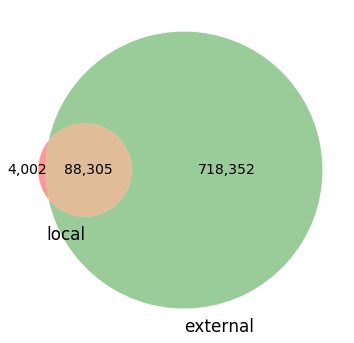

In [9]:
local_ids = set(local_notebook.index.tolist())
external_ids = set(external_notebook.index.tolist())
print(len(local_ids & external_ids))
with fig("d_e4_notebook_module_external_local", 8, 6):
    gcf = plt.figure()
    ax = gcf.add_subplot(111)
    venn = venn2(subsets=(local_ids, external_ids), set_labels=('local', 'external'), ax=ax)
    for label in venn.subset_labels:
        label.set_text("{0:,g}".format(int(label.get_text())))
    local_label = venn.subset_labels[0]
    xy = local_label.get_position()
    xy = (xy[0] - 0.06, xy[1])
    local_label.set_position(xy)

## Import Type

* import: `import numpy`
* import_from: `from sklearn import datasets`
* load_ext: `%load_ext autoreload`


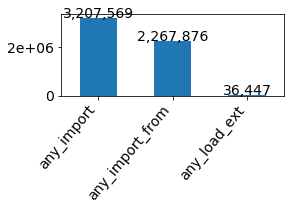

,0
any_import,3207569
any_import_from,2267876
any_load_ext,36447


In [10]:
 count = modules[["any_import_count", "any_import_from_count", "any_load_ext_count"]].sum().rename(
    lambda x: x[:-6]
).sort_values(ascending=False)

_, counts = display_counts(count, width=4, show_values=True, template="{0:,}", plot=False, logy=False)
ax = plt.gca()
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()
display(counts)

### Local

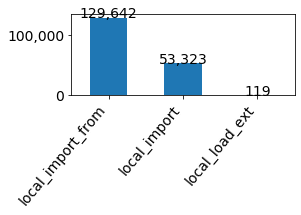

,0
local_import_from,129642
local_import,53323
local_load_ext,119


In [11]:
count = modules[["local_import_count", "local_import_from_count", "local_load_ext_count"]].sum().rename(
    lambda x: x[:-6]
).sort_values(ascending=False)

_, counts = display_counts(count, width=4, show_values=True, template="{0:,}", plot=False, logy=False)
ax = plt.gca()
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()
display(counts)

### External

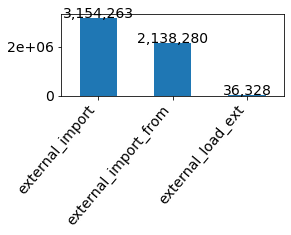

,0
external_import,3154263
external_import_from,2138280
external_load_ext,36328


In [12]:
count = modules[["external_import_count", "external_import_from_count", "external_load_ext_count"]].sum().rename(
    lambda x: x[:-6]
).sort_values(ascending=False)

_, counts = display_counts(count, width=4, show_values=True, template="{0:,}", plot=False, logy=False)
ax = plt.gca()
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()
display(counts)

## Which modules

### Full import

,0
numpy,586990
matplotlib.pyplot,419340
pandas,386237
os,143224
seaborn,118827
matplotlib,106066
sklearn,91020
sklearn.metrics,87431
time,81685
math,79819


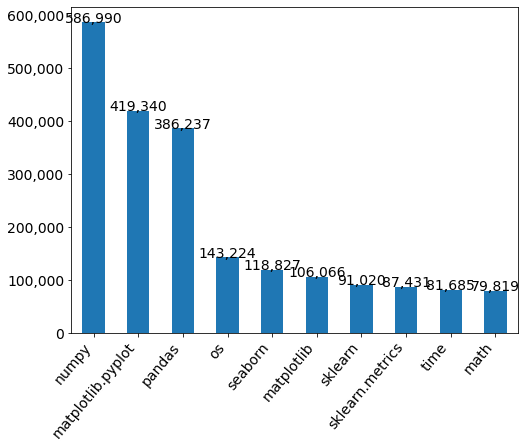

In [13]:
counter = Counter()
modules["any_any"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("d_e4_notebook_module_full_import", 8, 6):
    _, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)

### Toplevel

Percentage Analysis available at A4.RQ3

,0
numpy,587852
matplotlib,470507
pandas,386619
sklearn,224524
os,149693
scipy,140785
seaborn,119275
time,81685
math,79820
IPython,76478


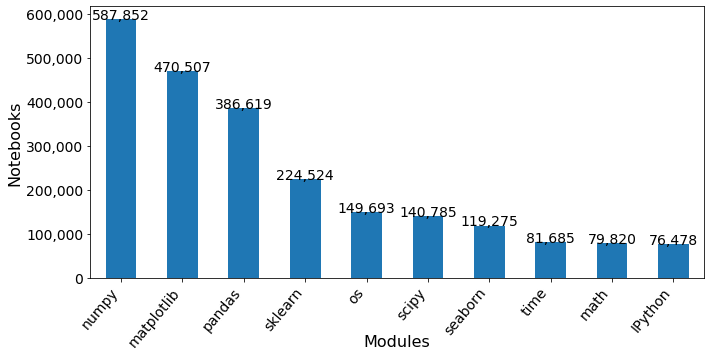

In [14]:
counter = Counter()
modules["toplevel_any_any"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("d_e4_notebook_module_toplevel", 11, 5):
    _, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)
    ax.set_ylabel("Notebooks")
    ax.set_xlabel("Modules")
    ax.xaxis.labelpad = -15
    #ax.yaxis.labelpad = -15

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


,0
numpy,66.298998
matplotlib,53.064619
pandas,43.603581
sklearn,25.322218
os,16.882644
scipy,15.877984
seaborn,13.452047
time,9.212580
math,9.002242
IPython,8.625325


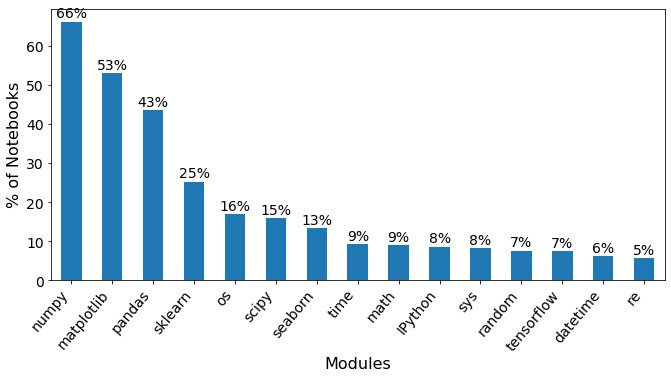

In [15]:
ncounts = counts / total_notebooks * 100
with fig("d_e4_notebook_module_toplevel_percentage", 11, 5):
    _, cnt = display_counts(
        ncounts, width=20, show_values=True, plot=False,
        cut=slice(None, 15), logy=False, template="{}%"
    )
    display(cnt)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)
    ax.set_ylabel("% of Notebooks")
    ax.set_xlabel("Modules")

## import

### Full import

,0
numpy,582090
matplotlib.pyplot,417239
pandas,383466
os,139093
seaborn,118646
sys,72517
time,70412
math,65033
tensorflow,64650
random,59378


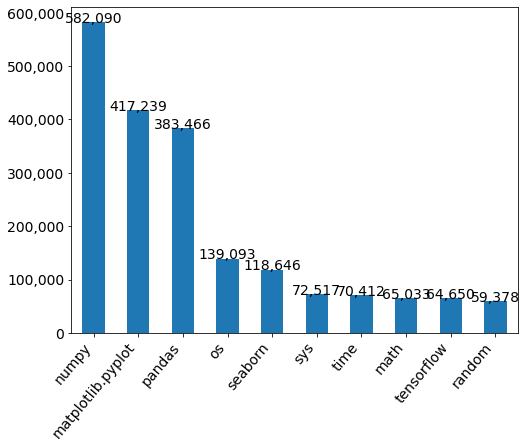

In [16]:
counter = Counter()
modules["any_import"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("d_e4_notebook_module_import_full_import", 8, 6):
    _, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)


### Toplevel

,0
numpy,582365
matplotlib,436929
pandas,383562
os,142857
seaborn,119082
sys,72517
time,70412
math,65034
tensorflow,64782
scipy,63049


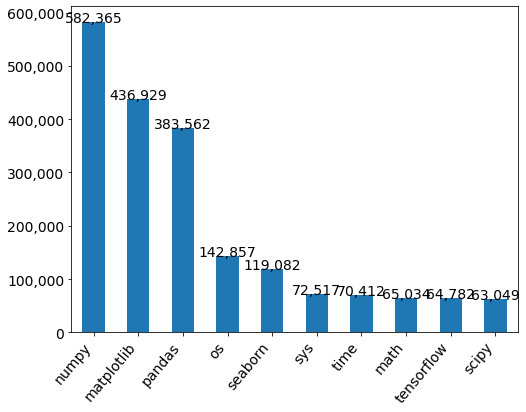

In [17]:
counter = Counter()
modules["toplevel_any_import"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("d_e4_notebook_module_import_toplevel", 8, 6):
    _, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)


## import from

### Full import

,0
sklearn.metrics,85392
sklearn,78800
sklearn.model_selection,75662
sklearn.linear_model,60610
sklearn.preprocessing,59680
IPython.display,58302
matplotlib,55805
__future__,49228
sklearn.ensemble,46333
collections,42199


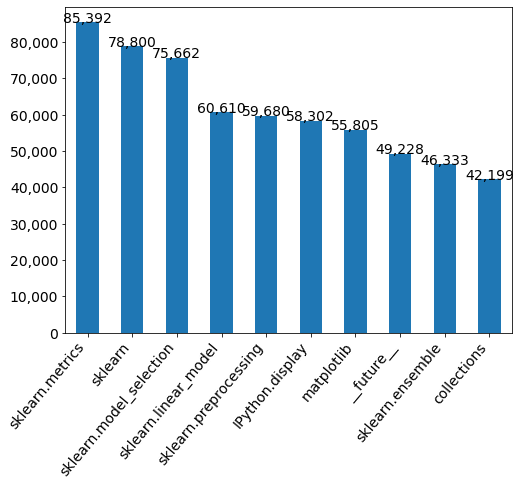

In [18]:
counter = Counter()
modules["any_import_from"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("d_e4_notebook_module_import_from_full_import", 8, 6):
    _, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)

### Toplevel

,0
sklearn,216494
scipy,97931
matplotlib,78143
IPython,73577
__future__,49228
keras,45984
collections,42225
pandas,28336
datetime,25529
numpy,25508


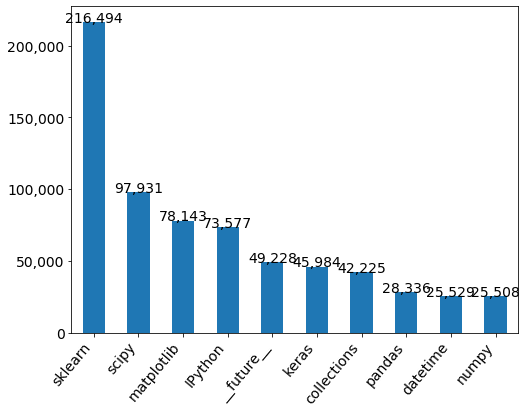

In [19]:
counter = Counter()
modules["toplevel_any_import_from"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("d_e4_notebook_module_import_from_toplevel", 8, 6):
    _, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)


## load_ext

### Full import

,0
autoreload,27396
sql,1926
watermark,1633
rpy2.ipython,1353
Cython,821
version_information,474
line_profiler,380
cython,338
autotime,294
memory_profiler,261


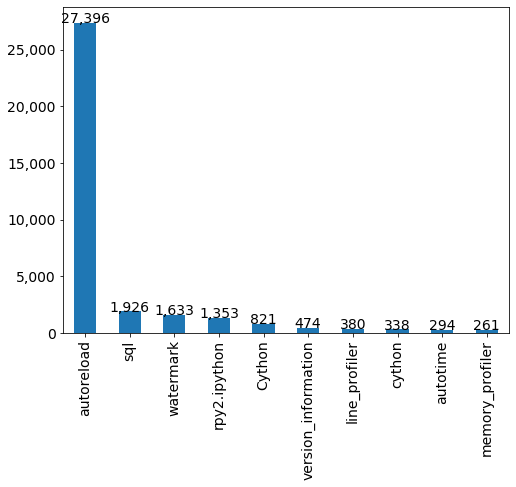

In [20]:
counter = Counter()
modules["any_load_ext"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("d_e4_notebook_module_load_ext_full_import", 8, 6):
    _, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)


### Toplevel

,0
autoreload,27396
sql,1926
watermark,1633
rpy2,1354
Cython,821
version_information,474
line_profiler,380
cython,338
autotime,294
memory_profiler,261


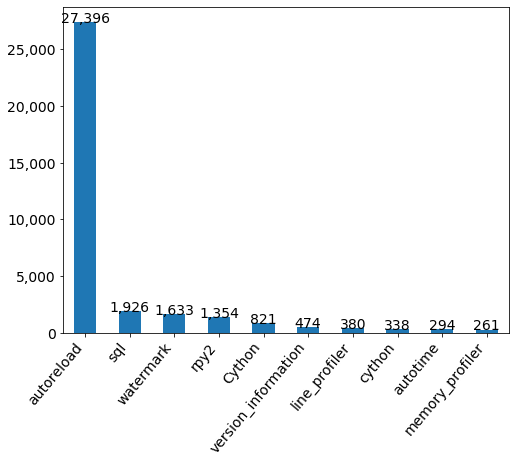

In [21]:
counter = Counter()
modules["toplevel_any_load_ext"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("d_e4_notebook_module_load_ext_toplevel", 8, 6):
    _, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)


## Test-related modules

,0
problem_unittests,2927
unittest,2620
testCases,1806
nose.tools,1228
testCases_v2,656
numpy.testing,453
test_helper,346
testCases_v3,336
doctest,332
asl_test_model_selectors,276


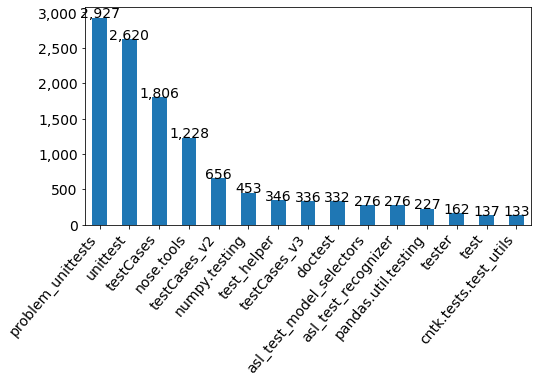

In [22]:
counter = Counter()
modules["any_any"].agg(lambda x: counter.update({
    y for y in x
    if is_test(y)
}))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("d_e4_notebook_tests", 8, 4):
    _, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 15), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)

Other Module analyses are available at A3.RQ3.RQ4